# Beoordeling Tijdreeksmodellen
*Auteurs: O.N. Ebbens (Artesia), D. Brakenhoff (Artesia)*

Een veelgestelde vraag is hoe je een geoptimaliseerd tijdreeksmodel moet beoordelen. Dit notebook laat zien welke methoden hiervoor gebruikt kunnen worden aan de hand van voorbeelden. De eenvoudigste methode voor de beoordeling van een tijdreeksmodel is een visuele beoordeling. Ook kunnen er diverse statistieken berekend worden voor een geoptimaliseerd tijdreeksmodel. Aan de hand van een stijghoogtereeks uit de praktijk worden deze methodes toegelicht. Voor de berekende statistieken uitgelegd wat de getallen betekenen en hoe deze gebruikt kunnen worden.

Een veelgebruikt criterium voor modelbeoordeling is de ‘fit’, die vaak wordt uitgedrukt met de afkorting EVP, wat staat voor het "Explained Variance Percentage". Hiermee wordt uitgedrukt hoe goed de simulatie op de metingen lijkt. Het notebook laat zien in hoeverre deze ‘fit’ een goede indicatie is voor de voorspellende waarde van het model.

Het notebook behandelt de meest gebruikte statistische toetsen. Speciale aandacht wordt besteed aan het kwantificeren van de betrouwbaarheid van de modelparameters. Welke voorwaarden zijn daarvoor vereist om dit te kunnen doen? Hoe kan je het model aanpassen zodat je aan de vereiste statistische voorwaarden voldoet?

<p style="color:red">%% DB: Ik heb wat tekst aanpassingen gedaan. Introductie kan nog wat duidelijker als de inhoud van het notebook compleet is denk ik. %%</p>

%% 
voorbeelden toevoegen van:
- een model met een hele lange responsefunctie die niet door de geheugentest komt
- Invloed op AIC/BIC, verschil tussen neerslag en verdamping samen
- Invloed op AIC/BIC, 3 winningen los of 3 winningen samen.
- Model met hoge EVP met grote onzekerheid in parameter (plaatje hieronder maken in notebook?). Hiermee laten zien waarom 2x standaarddeviatie belangrijk is.
- Modellen met hoge correlatie tussen 2 parameters (eentje aanpassen en vastzetten dan zien dat de fit goed blijft?). Makkelijkst met een recharge factor.
- Model wat door alle diagnostische toetsen heenkomt.


Nog meer uitleg geven over
- diagnostische toetsen
- waar dubbele procent-tekens staan (%%) moet nog iets gebeuren 
- Meer referenties opnemen?

%%

### Inhoudsopgave

Een tijdreeksmodel kan op een aantal onderdelen beoordeelt worden. In dit notebook komen de volgende onderwerpen aan bod:

- [Maken tijdreeksmodel](#tijdreeksmodel)
- [Visuele beoordeling](#visueel)
- [Validatie](#validatie)
- [Fit statistieken](#fit)
- [Betrouwbaarheid modelparameters](#betrouwbaarheid)
- [Correlatie modelparameters](#correlatie)
- [Geheugen van de responsefunctie](#geheugen)

## Beoordeling

Voor het gebruiken of afkeuren van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria worden vastgesteld voor de hierboven genoemde onderdelen. 

In [79]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt
from scipy.stats import norm, probplot, shapiro, normaltest

In [34]:
# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
ps.show_versions(numba=True)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.2
Scipy version: 1.5.2
Pandas version: 1.2.0
Pastas version: 0.17.0b
Matplotlib version: 3.3.2
numba version: 0.51.2


In [35]:
# instellingen voor tabelweergave
cmap = plt.get_cmap("RdBu")
norma = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

def cbg(val):
    color = mpl.colors.rgb2hex(cmap(norma(val)))
    return f"background-color: {color}"

def ctxt(val):
    bg = cmap(norma(val))
    c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
    return f"color: {c}"

## Maken tijdreeksmodel <a name="tijdreeksmodel"></a>

In dit notebook maken we gebruik van een simpel tijdreeksmodel om de grondwaterstand te simuleren met neerslag en verdamping als verklarende variabelen. 

In [4]:
# inlezen tijdreeksen
oseries = pd.read_csv("data/grondwaterstand.csv",
                      parse_dates=True,  squeeze=True, index_col=0)

neerslag = pd.read_csv("data/neerslag.csv", parse_dates=True,
                       squeeze=True, index_col=0)

verdamping = pd.read_csv("data/verdamping.csv", parse_dates=True,
                         squeeze=True, index_col=0)

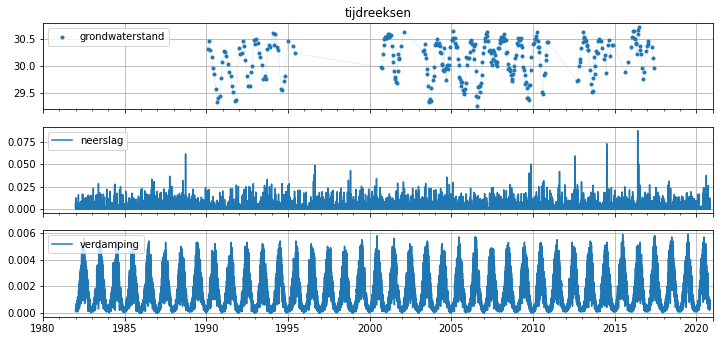

In [5]:
# laat de tijdreeksen zien in een figuur
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(12,6), sharex=True)
oseries.plot(ax=ax1, label='grondwaterstand', marker='.', lw=0.1, legend=True)
neerslag.plot(ax=ax2, label='neerslag')
verdamping.plot(ax=ax3, label='verdamping')
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(dt.datetime(1980,1,1), dt.datetime(2021,1,1))
    ax.legend(loc="upper left")
    ax.grid()
ax1.set_title('tijdreeksen');

In [6]:
# maken tijdreeksmodel
ml = ps.Model(oseries)
sm = ps.StressModel(neerslag-verdamping, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(sm)

In [7]:
ml.solve(report=False)

## Visuele beoordeling <a name="visueel"></a>

De eerste check om de betrouwbaarheid van het model in te schatten is vaak een visuele vergelijking van de modelsimulatie met de metingen. In onderstaande grafiek is deze vergelijking gemaakt. De modelresultaten en de metingen komen behoorlijk goed overeen. Ook is duidelijk dat de verschillen tussen het model en de metingen vooral onstaan bij de extremen, de dalen in de zomer en de pieken in de winter.

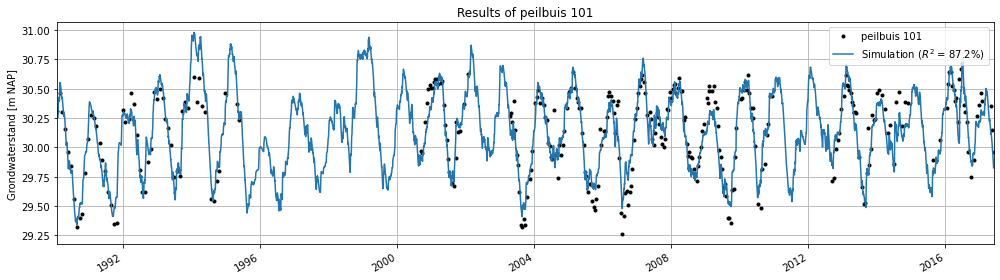

In [8]:
ax = ml.plot(figsize=(14,4))
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.grid()

## Validatie<a name="validatie"></a>

Wanneer er voldoende metingen zijn kan ervoor worden gekozen om een validatie uit te voeren. Hierbij wordt de tijdreeks met gemeten grondwaterstanden gesplitst in een trainingsperiode en een testperiode. Het tijdreeksmodel wordt gefit op de metingen in de trainingsperiode en er wordt een modelsimulatie gemaakt voor de testperiode. Het vergelijken van de gesimuleerde grondwaterstanden met de metingen in de testperiode geeft een goede indicatie hoe goed het model presteert.

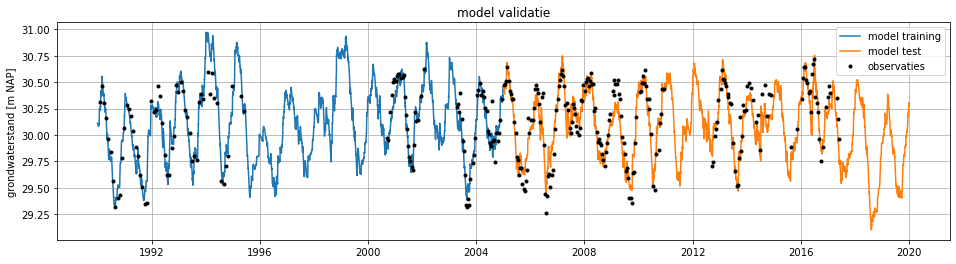

In [9]:
# train het model op periode 1990 - 2005, test het model op de periode 2005 - 2020
ml_train1 = ml.copy()
ml_train1.solve(tmin='1990', tmax='2005', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train1.simulate(tmin='1990', tmax='2005'), label='model training')
ax.plot(ml_train1.simulate(tmin='2005', tmax='2020'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_ylabel('grondwaterstand [m NAP]');

De trainings- en testperiode kunnen zelf worden gekozen. De testperiode kan ook voor de trainingsperiode liggen, zie voorbeeld hieronder. Let er wel op dat er van de verklarende tijdreeksen, in dit geval neerslag en verdamping, metingen beschikbaar moeten zijn voor zowel de test- als de trainingsperiode.

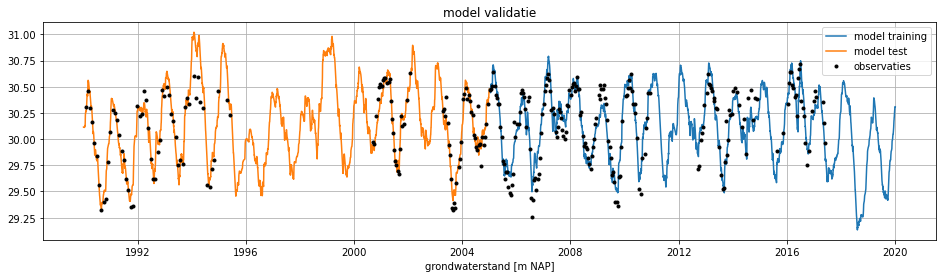

In [10]:
# train het model op periode 2005 - 2020, test het model op de periode 1990 - 2005
ml_train2 = ml.copy()
ml_train2.solve(tmin='2005', tmax='2020', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train2.simulate(tmin='2005', tmax='2020'), label='model training')
ax.plot(ml_train2.simulate(tmin='1990', tmax='2005'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_xlabel('grondwaterstand [m NAP]');

## Fit statistieken<a name="fit"></a>

Naast de visuele vergelijking van gemodelleerde en gemeten grondwaterstanden bestaan er ook verschillende statistieken die iets zeggen over de fit tussen gemodelleerde en gemeten grondwaterstanden. Een aantal veelgebruikte fit statistieken zijn:

- **som van de kwadratische fout / sum of the squares of the error**
<br>
<br>
$\text{SSE} = \sum_{i=1}^{N}(x_i - y_i)^2$
<br>
<br>
- **gemiddelde absolute fout / mean absolute error**
<br>
<br>
$\text{MAE} = \sum_{i=1}^{N}\frac{|x_i - y_i|}{N}$ 
<br>
<br>
- **wortel van de kwadratisch gemiddelde fout / root mean squared error** 
<br>
<br>
$\text{RMSE} = \sqrt{\sum_{i=1}^{N}\frac{ (x_i - y_i)^2}{N}}$
<br>
<br>
- **verklaarde variantie / explained variance percentage**
<br>
<br>
$\text{EVP} = \frac{\sigma_h^2 - \sigma_r^2}{\sigma_h^2} * 100$
<br>
<br>
- **determinatiecoëfficiënt / r-squared**
<br>
<br>
$R^2 = 1-  \frac{N-1}{N-N_{param}}*\frac{\sum_{i=1}^{N}(x_i - y_i)^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$

<br> 
$N$ is het aantal metingen.
<br> 
$N_{param}$ is het aantal vrije parameters.
<br>
$x_i$ en $y_i$ zijn respectievelijk de gemeten en de gemodelleerde grondwaterstand op tijdstip $i$.
<br>
$\sigma_h^2$ en $\sigma_r^2$ zijn respectievelijk de variantie in de gemeten grondwaterstanden en de residuën.
<br>

%% openstaande vragen:
- waarom zit de correctie voor aantal parameters bij de berekening van r-squared? 
- verschil verklaarde variantie/r-squared/NSE, hoe op te nemen in deze uitleg?
%%

In [11]:
# fit statistics kunnen in pastas worden opgevraagd met `ml.stats.<naam statische parameter>()`
print(f'Mean absolute error (mae)                         : {ml.stats.mae():.3f}')
print(f'Root mean squared error (rmse)                    : {ml.stats.rmse():.3f}')
print(f'Sum of the squares of the error (sse)             : {ml.stats.sse():.3f}')
print(f'Explained variance percentage (evp)               : {ml.stats.evp():.1f}%')
print(f'R-squared (rsq)                                   : {ml.stats.rsq():.3f}')

Mean absolute error (mae)                         : 0.096
Root mean squared error (rmse)                    : 0.124
Sum of the squares of the error (sse)             : 4.975
Explained variance percentage (evp)               : 87.2%
R-squared (rsq)                                   : 0.872


### model validatie

Wanneer een model validatie is uitgevoerd kunnen de gesimuleerde en gemeten grondwaterstanden ook worden vergeleken met behulp van dezelfde statistieken. In principe wordt de R-squared enkel gebruikt om de "goodness of fit" te berekenen bij een model kalibratie. Wanneer wordt berekent hoe goed de voorspellingen van het model zijn wordt gebruik gemaakt van de Nash-Sutcliffe model efficiëncy coëfficient. Deze is equivalent aan de R-squared values alleen worden nu niet het aantal vrije modelparameters meegenomen. 

%% Misschien wat onduidelijk het verschil tussen r-squared en NSE, komt hiervandaan https://stats.stackexchange.com/questions/185898/difference-between-nash-sutcliffe-efficiency-and-coefficient-of-determination %%

**Nash-Sutcliffe model efficiency**
<br>
<br>
$NSE = 1-  \frac{\sum_{i=1}^{N}(x_i - y_{i, sim})^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}$
<br>
<br>
$y_{i, sim}$ is de met het model voorspelde grondwaterstand.

In [12]:
sim = ml_train2.simulate(tmin='1990', tmax='2005')
obs = ml_train2.oseries.series['1990':'2004']

print('fit statistieken validatie periode 1990 - 2005')
print('----------------------------------------------')
print(f'Mean absolute error (mae)                         : {ps.stats.mae(obs=obs, sim=sim):.3f}')
print(f'Root mean squared error (rmse)                    : {ps.stats.rmse(obs=obs, sim=sim):.3f}')
print(f'Sum of the squares of the error (sse)             : {ps.stats.sse(obs=obs, sim=sim):.3f}')
print(f'Explained variance percentage (evp)               : {ps.stats.evp(obs=obs, sim=sim):.1f}%')
print(f'Nash-Sutcliffe model efficiency coefficient (nse) : {ps.stats.nse(obs=obs, sim=sim):.3f}')

fit statistieken validatie periode 1990 - 2005
----------------------------------------------
Mean absolute error (mae)                         : 0.088
Root mean squared error (rmse)                    : 0.122
Sum of the squares of the error (sse)             : 1.815
Explained variance percentage (evp)               : 88.7%
Nash-Sutcliffe model efficiency coefficient (nse) : 0.881


In [13]:
# de prestatie van het model kan worden berekend met de statistieken in `ps.stats.<naam statische parameter>()`

sim = ml_train1.simulate(tmin='2005', tmax='2020')
obs = ml_train1.oseries.series['2005':'2019']

print('fit statistieken validatie periode 2005 - 2020')
print('----------------------------------------------')
print(f'Mean absolute error (mae)                         : {ps.stats.mae(obs=obs, sim=sim):.3f}')
print(f'Root mean squared error (rmse)                    : {ps.stats.rmse(obs=obs, sim=sim):.3f}')
print(f'Sum of the squares of the error (sse)             : {ps.stats.sse(obs=obs, sim=sim):.3f}')
print(f'Explained variance percentage (evp)               : {ps.stats.evp(obs=obs, sim=sim):.1f}%')
print(f'Nash-Sutcliffe model efficiency coefficient (nse) : {ps.stats.nse(obs=obs, sim=sim):.3f}')

fit statistieken validatie periode 2005 - 2020
----------------------------------------------
Mean absolute error (mae)                         : 0.107
Root mean squared error (rmse)                    : 0.134
Sum of the squares of the error (sse)             : 3.596
Explained variance percentage (evp)               : 85.0%
Nash-Sutcliffe model efficiency coefficient (nse) : 0.844


### overzicht fit statistieken

| parameter              | waarde bij optimale fit | minimum  | maximum  |
|------------------------|-------------------------|----------|----------|
| $\text{sse}$           | 0                       | 0        | $\infty$ |
| $\text{mae}$           | 0                       | 0        | $\infty$ |
| $\text{rmse}$          | 0                       | 0        | $\infty$ |
| $\text{evp}$           | 100%                    | 0        | 100      |
| $R^2$                  | 1                       | 0        | 1        |
| $\text{nse}$           | 1                       | $-\infty$| 1        |

### Overfitting

<p style="color:red">%% DB: wel een hele kleine verbetering van EVP, kunnen we geen beter voorbeeld vinden? %%</p>

Wanneer er meer verklarende variabelen, en bijbehorende modelparameters, aan een tijdreeksmodel worden toegevoegd verbetert over het algemeen de fit. Zelfs wanneer de grondwaterstanden niet wordt beïnvloed door de verklarende variabele. Immers, hoe meer vrijheidsgraden (parameters) het model heeft des te makkelijker het model op de metingen kan worden gefit. Wanneer zo'n verklarende variabele wordt toegevoegd verbetert de voorspellende waarde van het model niet. Het fenomeen waarbij meer parameters worden toegevoegd aan het model dan kan worden gerechtvaardigt op basis van de metingen heet overfitting. 

Het is dus niet mogelijk om op basis van enkel de fit statistieken aan te geven of het model verbetert na het toevoegen van een verklarende variabele. Twee statistieken die wel rekening houden met overfitting zijn:

- **aic**: Akaike information criterion
- **bic**: Bayesian information criterion

Zowel de `aic` als de `bic` zijn een maat voor de relatieve hoeveelheid informatie die verloren is gegaan in het model. Het zijn dus relatieve waarde en kunnen het best gebruikt worden om verschillende modellen van dezelfde meetreeks met elkaar te vergelijken. Wanneer de `aic` en `bic` lager worden na het toevoegen van een verklarende variabele betekent dit dat het model verbetert (er gaat relatief minder informatie verloren). Als de aic en bic hoger worden dan heeft het toevoegen van de parameters niet bijgedragen aan een verbetering van het model.

In het voorbeeld hieronder is de `evp`, `aic` en `bic` van een model zonder en met een staptrend getoond. Door het toevoegen van de staptrend is de `evp` van het model toegenomen met 0.36%. De aic en de bic zijn ook toegenomen. Dit betekent dat de fit van het model weliswaar is verbeterd maar de voorspellende waarde %%IS DIT ZO??%% is verslechterd.

In [14]:
# evp, aic en bic huidig model
print(f'Explained variance percentage (evp)  : {ml.stats.evp():.2f}%')
print(f'R-squared (rsq)                      : {ml.stats.rsq():.2f}')
print(f'Akaike information criterion (aic)   : {ml.stats.aic():.2f}')
print(f'Bayesian information criterion (bic) : {ml.stats.bic():.2f}')


Explained variance percentage (evp)  : 87.18%
R-squared (rsq)                      : 0.87
Akaike information criterion (aic)   : 6.79
Bayesian information criterion (bic) : 25.68


In [15]:
# voeg een steptrend toe aan het model
ml_step = ml.copy()
sm = ps.stressmodels.StepModel("2007", "step", rfunc=ps.One)
ml_step.add_stressmodel(sm)
ml_step.solve(tmin='1990', report=False)

In [16]:
# evp, aic en bic model met steptrend
print(f'Explained variance percentage  : {ml_step.stats.evp():.2f}%')
print(f'R-squared (rsq)                : {ml_step.stats.rsq():.2f}')
print(f'Akaike information criterion   : {ml_step.stats.aic():.2f}')
print(f'Bayesian information criterion : {ml_step.stats.bic():.2f}')

Explained variance percentage  : 87.54%
R-squared (rsq)                : 0.88
Akaike information criterion   : 10.85
Bayesian information criterion : 37.29


In [17]:
# in pastas kan je een overzicht krijgen van alle fit statistieken
ml.stats.summary()

,Value
Statistic,
rmse,0.124261
rmsn,0.094257
sse,4.975068
mae,0.096235
nse,0.871814
evp,87.182783
rsq,0.871847
bic,25.679383
aic,6.791122


## Betrouwbaarheid modelparameters<a name="betrouwbaarheid"></a>

Naast de beoordeling van de model fit is het ook van belang om te kijken naar de modelparameters. Externe invloeden worden gemodelleerd met responsfuncties die ieder één of meerdere parameters bevatten. Daarnaast kunnen in tijdreeksmodellen ook nog een constante en een noisemodel worden toegevoegd. In het voorbeeld hieronder zijn de parameters weergegeven van een tijdreeksmodel met recharge en een staptrend als externe invloeden. 

In [18]:
# voorbeeld parameters van model met recharge en step trend 
ml_step.parameters[['initial', 'optimal', 'pmin', 'pmax', 'stderr']]

,initial,optimal,pmin,pmax,stderr
recharge_A,210.475594,472.754740,0.00001,21047.559369,34.935570
recharge_n,1.000000,1.102530,0.10000,100.000000,0.038636
recharge_a,10.000000,100.590483,0.01000,10000.000000,11.382372
step_d,1.000000,0.053916,0,NaN,0.027539
step_tstart,732677.000000,732677.000000,612411,825914.000000,NaN
constant_d,30.124737,29.868226,NaN,NaN,0.024003
noise_alpha,17.000000,42.683869,0.00001,5000,6.424809


Per parameters zijn de volgende waarden weergegeven:
- **initial**: de initiële waarde
- **optimal**: de geoptimaliseerde waarde
- **pmin en pmax**: de bandbreedte waarbinnen de parameters worden geoptimaliseerd
- **stderr**: de standaarddeviatie van de geoptimaliseerde parameter

De berekende standaarddeviaties zijn alleen betrouwbaar als aan een aantal voorwaarden wordt voldaan. Deze voorwaarden zijn hieronder uitgewerkt. Daaronder wordt behandeld hoe je de standaarddeviatie kan gebruiken om meer inzicht te krijgen in de modelresultaten.

<div class="alert alert-info">
    
<b>vuistregel:</b> 
    
Als de standaarddeviaties van de parameter worden gebruikt, is een diagnostische check van het ruismodel nodig.
    
</div>



### Model diagnostiek

De berekende standaarddeviaties zijn betrouwbaar als aan een aantal voorwaarden wordt voldaan. De twee voorwaarden voor de met het ruismodel berekende ruis zijn dat het:
1. zich gedraagt als witte ruis met een gemiddelde van nul.
2. niet gecorreleerd is aan een verklarende tijdreeks.

Er is sprake van witte ruis wanneer:
1. er geen significante autocorrelatie in de ruis aanwezig is
2. de ruis homoscedastisch is
3. de ruis voldoet aan een, bij voorkeur normale, statistische verdeling.

Het is aan te bevelen om te checken of aan deze voorwaarden wordt voldaan wanneer gebruik wordt gemaakt van de standaarddeviaties van de parameters. De voorwaarden voor de ruis kunnen gecheckt worden via een aantal statistische toetsen. Deze test worden meestal uitgevoerd met een nulhypothese ($H_0$) en een alternatieve hypothese ($H_A$):

- $H_0$: de ruis is onafhankelijk, homoscedastisch of normaal verdeeld
- $H_A$: de ruis is niet onafhankelijk, homoscedastisch, of normaal verdeeld

Voor een hypothese toets wordt een bepaalde statistische waarde berekend (bijv. $Q_{test}$), die vervolgens wordt vergeleken met een theoretische waarde op basis van een bepaalde verdeling (bijv. $\chi^2_{\alpha, h}$) die afhankelijk is van een significantieniveau (bijv. $\alpha=0.05$) en soms afhankelijk is van het aantal vrijheidsgraden $h$. Het resultaat is het wel of niet verwerpen van de nulhypothese. Dit resultaat kan nooit gebruikt worden om de alternatieve hypothese te accepteren. Wanneer bij de test voor autocorelatie de nulhypothese niet verworpen wordt kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de ruis maar we kunnen niet concluderen dat er geen autocorrelatie is.

In deze paragraaf worden de 3 voorwaarden voor witte ruis en de daarbij horende statistische toesten verder toegelicht.

%% 
Nog wat vragen:
- waarom twee testen voor normale verdeling en autocorelatie? Wat als de ene wel door de test komt en de ander niet?
- Klopt het dat dit alle voorwaarden zijn voor witte ruis?
- klopt het wel wat ik zeg over het accepteren van de nulhypothese maar het niet verwerpen van de alternatieve hypothese?
%%

#### Autocorrelatie

Het kan gebeuren dat een tijdreeks gecorreleerd is met een in de tijd verschoven versie van zichzelf. Als dat het geval is spreken we van autocorrelatie. De autocorrelatie kan worden weergegeven in een autocorrelatiediagram zoals hieronder. Hierin is op de x-as de verschuiving in de tijd weergegeven (lag) en op de y-as de hierbij berekende correlatie. De autocorrelatie wordt weergegeven tot een maximale verschuiving van 1 jaar (365 dagen). De blauwe band in de grafiek geeft het 95% betrouwbaarheidsinterval weer. Wanneer 95% van de berekende autocorrelaties binnen dit interval liggen kunnen we concluderen dat er geen significante autocorrelatie aanwezig is in de reeks.



%% Vragen:
- Als het betrouwbaarheidsinterval wordt berekend op basis van de autocorrelaties en je vervolgens gaat toetsen of de autocorrelaties binnen dit betrouwbaarheidsinterval liggen dan komt deze altijd door de toets toch? Of maak ik nu een denkfout? Waar wordt de blauwe band mee berekend?
- dit model komt niet door de Runs test, enig idee waarom niet?
   %%

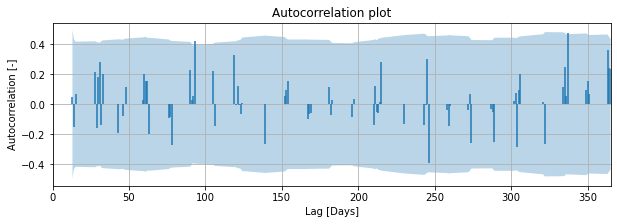

In [19]:
ax = ps.stats.plot_acf(ml.noise(), acf_options={"max_gap": 60, "min_obs": 24}, 
                       figsize=(10,3), alpha=0.01)



Naas de visuele check op autocorrelatie bestaan er ook statische toestsen om te checken of er autocorrelatie aanwezig is. Deze zijn in onderstaande tabel weergegeven. De eerste twee methodes `ljung_box` en `Durbin-Watson` zijn alleen geschikt voor equidistante tijdreeksen. In tijdreeksen van grondwaterstanden missen vaak metingen en dus zijn deze niet equidistant. Voor het checken van autocorrelatie worden daarom meestal de `Stoffer-Toloi` en de `Runs Test` gebruikt die wel kunnen omgaan met niet equidistante reeksen.


| Naam | Beschrijving | geschikt voor niet equidistante reeksen |
|:-----|:-----------------------------------------|:---------------:|
| Ljung-Box test| Deze test checkt of de autocorrelatie in een tijdreeks significant verschilt van nul| Nee |
| Durbin-Watson test | Deze test checkt de autocorrelatie bij een verschuiving van één tijdstap. | Nee |
| Stoffer-Toloi test | Deze test is vergelijkbaar met de Ljung-Box test, maar aangepast voor missende waarde | Ja |
| Runs test | Deze test checkt of de waarden in een tijdreeks willekeurig zijn zonder uit te gaan van een bepaalde kansverdeling. | Ja |

%% Hoe zit het met Stoffer-Toloi? Hoeveel data mag er missen? Kan je ook bij een frequentie waar soms iets mist toch deze test doen?%%

In [20]:
alpha = 0.05

stat, p = ps.stats.stoffer_toloi(ml.noise(), lags=15, freq="D")

print('Stoffer-Toloi test:')
if p > alpha:
    print("Nullhypothese niet verworpen, geen significante autocorrelatie. p =", p.round(2))
else:
    print("Nullhypothese verworpen")


print('\nRuns test:')
stat, p = ps.stats.runs_test(ml.noise())

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis")

Stoffer-Toloi test:
Nullhypothese niet verworpen, geen significante autocorrelatie. p = 0.17

Runs test:
Reject the Null-hypothesis


#### Homoscedasticiteit

Een reeks is homoscedastisch als alle waarden dezelfde eindige variantie hebben. Bij ons tijdreeksmodel betekent dit dat de ruis onafhankelijk is van de gemeten grondwaterstanden. Dit is hieronder visueel weergegeven door deze waarden tegen elkaar uit te zetten in een grafiek.

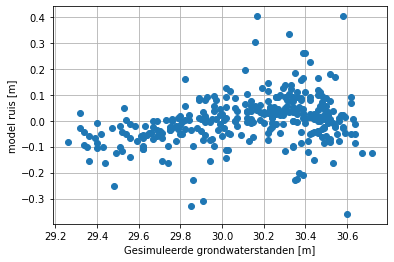

In [21]:
plt.plot(ml.observations(), ml.noise(), marker="o", linestyle=" ")
plt.xlabel("Gesimuleerde grondwaterstanden [m]")
plt.ylabel("model ruis [m]");
plt.grid()

Er bestaan verschillende statistische toetsen om te checken of een reeks homoscedastisch is.

| Naam | Beschrijving | geschikt voor niet equidistante reeksen |
|:-----|:----------------------------------|----------------:|
|Engle test| |Onbekend|
|Breusch-Pagaan test| niet beschikbaar | |Onbekend|

%% Komen deze testen nog of moeten we aangeven dat dit nog niet kan met pastas? %%

#### Normale verdeling

Een veelgebruikte aanname is dat de ruis normaal verdeeld is. In principe is het ook mogelijk dat er een andere kansverdeling bij de ruis hoort. De verdeling van de ruis kan weergegeven worden met een histogram in combinatie met een kansverdeling. 

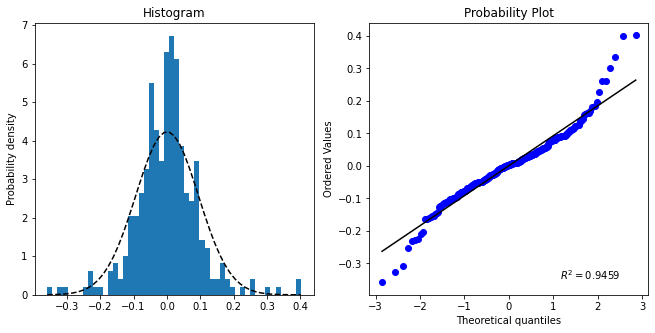

In [23]:
# Plot the histogram for normality and add a 'best fit' line
bins=50
series = ml.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")

# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('b')
ax2.get_lines()[1].set_color("k")

Het is een beruchte uitdaging om te bepalen of een tijdreeks normaal verdeeld is. Er bestaan wel testen maar deze zijn niet altijd betrouwbaar. Aan de ene kant geldt dat als er weinig metingen beschikbaar zijn, de afwijkingen van een normale verdeling erg sterk moeten zijn voordat de test ze kan detecteren. Aan de andere kant geldt dat bij een groot aantal metingen, hele kleine (irrelevante) afwijkingen van de normale verdeling al tot significante uitkomsten leiden.  Het is daarom lastig objectief vast te stellen of ruis normaal verdeeld is.

| Naam | Beschrijving | Geschikt voor niet equidistante tijdreeksen? |
|:-----|:------------|----------------:|
| Shapiro-Wilk | Deze test checkt of de data uit een normale verdeling is getrokken | Onbekend |
| D'Agostino | Deze test checkt of de ruis voldoet aan een normale verdeling (H0 hypothesis). | Onbekend |


%% vragen:
- werken deze testen voor niet equidistante tijdreeksen?
- waarom zijn de p-waarden zo klein bij kleine tijdstappen? Tijdstap van 70 dagen lukt het wel, gevoelsmatig wel weer heel groot.
%%

In [24]:
stat, p = shapiro(ml.noise())

print('Shapiro-Wilk test:')
if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", np.round(p, 2))
else:
    print("Reject the Null-hypothesis. p =", np.round(p, 3))
    

stat, p = normaltest(ml.noise())

print("\nD'Agostino test:")
if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(3))

Shapiro-Wilk test:
Reject the Null-hypothesis. p = 0.0

D'Agostino test:
Reject the Null-hypothesis. p = 0.0


#### Overzicht visuele en diagnostische toetsen

In [25]:
# diagnostische toetsen voor het model met steptrend
ml_step.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.95,0.00,True
D'Agostino,Normality,32.75,0.00,True
Runs test,Autocorr.,-3.29,0.00,True
Stoffer-Toloi,Autocorr.,16.39,0.29,False


c:\users\oebbe\02_python\pastas\pastas\stats\tests.py:616: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")


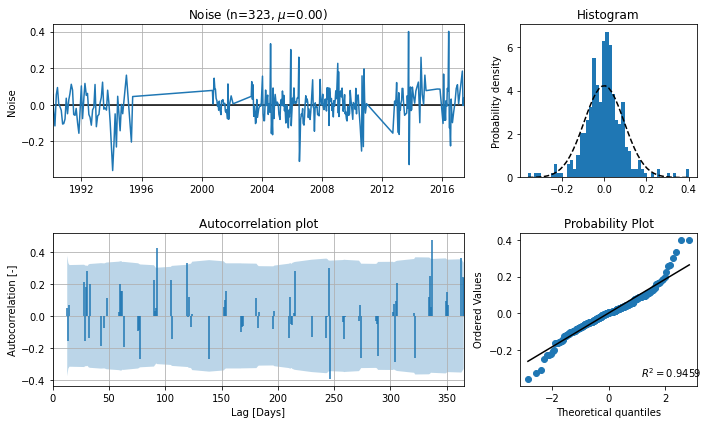

In [26]:
# visualisatie diagnostische toetsen
ml.plots.diagnostics(acf_options={"max_gap": 60, "min_obs": 24});

### Standaarddeviatie parameters

Wanneer wordt voldaan aan bovengenoemde voorwaarden kan de standaarddeviatie van de modelparameters worden gebruikt om de betrouwbaarheid van het model in te schatten. Zoals bijvoorbeeld hieronder bij het plotten van de bandbreedte van een modelsimulatie en de bandbreedte van een responsfunctie.

metingen binnen betrouwbaarheidsinterval: 95.4%


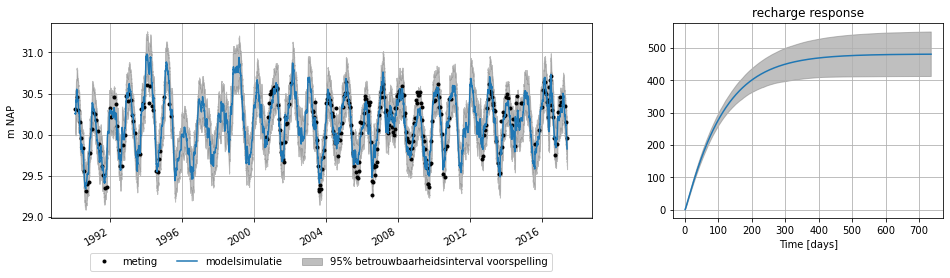

In [73]:
# Plot betrouwbaarheidsinterval
df = ml.fit.prediction_interval()
fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
obs = ml.oseries.series_original 
sim = ml.simulate()
inside = (obs > df.loc[obs.index, 0.025]) & (obs < df.loc[obs.index, 0.975])
print(f'metingen binnen betrouwbaarheidsinterval: {np.count_nonzero(inside) / len(inside) * 100:.1f}%') 

obs.plot(ax=ax1, linestyle='', marker='.', color='k', label='meting',
         x_compat=True)
sim.plot(ax=ax1, x_compat=True, label='modelsimulatie')
ax1.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                zorder=-1, alpha=0.5, label="95% betrouwbaarheidsinterval voorspelling")
ax1.set_ylabel('m NAP')
ax1.grid()
ax1.legend(bbox_to_anchor=(0.5, -0.15), ncol=3, loc='upper center')

# plot recharge response
ax2 = fig.add_subplot(gs[0, 1])
df = ml.fit.ci_step_response("recharge", alpha=0.05, n=1000)
rch_response = ml.get_step_response("recharge", add_0=True)

rch_response.plot(ax=ax2)
ax2.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% confidence")
ax2.grid()
ax2.set_title('recharge response');

De standaarddeviatie kan ook worden gebruikt om de betrouwbaarheid van een model te toetsen. Bijvoorbeeld door te kijken naar de grootte van de standaarddeviatie t.o.v. de geoptimaliseerde parameterwaarde. Hieronder testen we of de absolute, geoptimaliseerde parameterwaarde groter is dan 2x de standaarddeviatie. In dit geval komen alle parameters behalve de `step_d` parameter door onze test. Dit betekent dat de invloed van de steptrend een grote onzekerheid kent. 

%%Is deze check wel interessant? En we mogen deze ook helemaal niet doen volgende onze eigen analyse want de 3 voorwaarden voor witte ruis zijn niet getest%%

In [74]:
# check of de waarde van de parameter groter is dan 2x de standaarddeviatie
parameters = ml_step.parameters[ml_step.parameters.vary]
parameters['optimal'].abs() > (parameters['stderr']*2)

recharge_A      True
recharge_n      True
recharge_a      True
step_d         False
constant_d      True
noise_alpha     True
dtype: bool

## Parameter correlaties<a name="correlatie"></a>

Ook is het van belang om te kijken naar de parameter correlaties. Wanneer twee modelparameters sterk gecorreleerd zijn betekent dit dat bijna dezelfde modelresultaten kunnen worden verkregen met andere waardes van deze twee parameters. Hieronder is de correlatiematrix weergegeven van de parameters in het voorbeeldmodel.

In [29]:
# correlatiecoëfficiënten (rho)
ml_step.fit.pcor.style.applymap(cbg).applymap(ctxt).set_precision(2)

,recharge_A,recharge_n,recharge_a,step_d,constant_d,noise_alpha
recharge_A,1.00,-0.47,0.83,-0.13,-0.64,0.01
recharge_n,-0.47,1.00,-0.80,0.05,0.30,-0.01
recharge_a,0.83,-0.80,1.00,-0.10,-0.54,-0.00
step_d,-0.13,0.05,-0.10,1.00,-0.41,0.02
constant_d,-0.64,0.30,-0.54,-0.41,1.00,-0.00
noise_alpha,0.01,-0.01,-0.00,0.02,-0.00,1.00


Uit de parameter correlaties van het model volgt dat de recharge parameters `A,n & a` en de constante `constant_d` een absolute correlatiecoëfficient groter dan 0.5 hebben. Dit betekent dat met een andere set aan parameter waarden redelijk vergelijkbare resultaten kunnen worden verkregen. In dit geval wordt de grondwaterstand berekend als de som van de bijdrage van de recharge en de constante. Een lagere constante kan relatief eenvoudig gecorrigeerd worden door een grotere bijdrage van de recharge. In dit geval is de grote correlatie dan ook niet erg problematisch voor de bruikbaarheid van het model. Grote parameter correlaties kunnen wel problematisch zijn wanneer je de bijdragen van verschillen verklarende variabelen los van elkaar wilt bekijken terwijl de parameters van de verklarende variabelen sterk gecorreleerd zijn. Een voorbeeld hiervan wordt hieronder uitgewerkt. 

**voorbeeld problematische parameter correlaties**<br>
Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruibkaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.

%%VOORBEELD NOG UITWERKEN%%

In [30]:
# eventueel voorbeeld uitwerken wanneer correlatie een probleem is


## Geheugen<a name="geheugen"></a>

Een tijdreeksmodel is opgebouwd uit één of meerdere externe invloeden. Deze invloeden kunnen gemodelleerd worden door middel van een responsfunctie. De responsfunctie geeft aan hoe een eenheidsimpuls van een stress (externe invloed) wordt omgezet naar een verandering in de grondwaterstand. De responsfunctie bevat daarmee informatie over hoe lang het duurt voordat een verandering in een externe invloed niet meer terug te zien is als een verandering in de grondwaterstand. In het geval van recharge kan je dit zien als de tijd die het duurt voordat de grondwaterstand weer op het oude niveau is na een regenbui. Deze tijd wordt ook wel het geheugen van een externe invloed genoemd.

Het geheugen van de verschillende invloeden is van belang bij het beoordelen van een tijdreeksmodel. Het gaat hierbij met name om de verhouding tussen de lengte (tijdsduur) van het tijdreeksmodel en het geheugen van de verschillende invloeden. Stel het tijdreeksmodel beslaat een periode van één jaar en het geheugen van de neerslagrespons is twee jaar. Dan is het effect van neerslag op dag één van het tijdreeksmodel nog niet uitgewerkt op de laatste dag van het tijdreeksmodel. Dit maakt het erg lastig om de invloed van de neerslag goed te schatten. Vaak wordt daarom als eis aangehouden dat de lengte van de tijdreeks groter moet zijn dan twee maal het geheugen van een externe invloed. 

Hieronder zijn van twee modellen de block response en de modelresultaten in één figuur geplot. Bij het eerste model is de lengte van het tijdreeksmodel een aantal maal groter dan het geheugen van de responsefunctie. Dit model voldoet daarmee aan de eis. Bij het tweede model is het geheugen van de responsfunctie langer dan de duur van het tijdreeksmodel, dit model voldoet niet aan de ijs.

#### voorbeeld geheugen 1

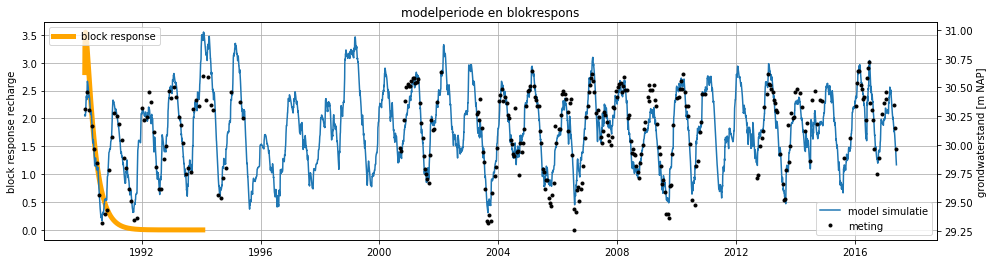

In [75]:
# get response function
sm = ml.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16,4))
block_resp = resp_func.block(ml.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=5)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)
ax.set_title('modelperiode en blokrespons')
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml.simulate(), label='model simulatie')#, lw=0.2)
ax2.plot(oseries['1990':], marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(loc=4)

#### Voorbeeld geheugen 2

In [95]:
# # code om model te genereren
# import hydropandas as hpd
# o = hpd.GroundwaterObs.from_dino(location='B52C0508', filternr=2)['2013-1-1':'2014-7-1']
# knmi_oc = hpd.ObsCollection.from_knmi(xmid=[o.x], ymid=[o.y],
#                                       meteo_vars=('RD', 'EV24'),
#                                       start=[o.index.min(), o.index.min()],
#                                       end=[o.index.max(),o.index.max()],
#                                       cache=True,
#                                       verbose=True)
# knmi_oc
# ml_B52C0508 = ps.Model(oseries=o['stand_m_tov_nap'])
# sm = ps.StressModel(knmi_oc.iloc[0]['obs']['RD'] - knmi_oc.iloc[1]['obs']['EV24'], 
#                     rfunc=ps.Gamma, name="recharge")
# ml_B52C0508.add_stressmodel(sm)
# ml_B52C0508.solve()
# ml_B52C0508.to_file(r'data\voorbeeld_geheugen.pas')

In [96]:
ml_voorbeeld = ps.io.load(os.path.join('data','voorbeeld_geheugen.pas'))
ml_voorbeeld.solve(report=False)

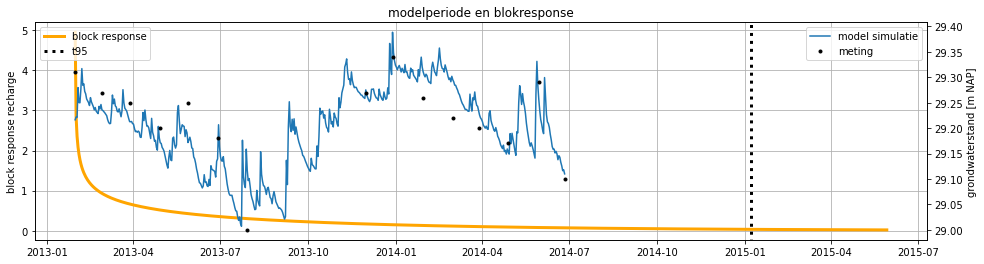

In [97]:
# get response functie
sm = ml_voorbeeld.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16,4))
block_resp = resp_func.block(ml_voorbeeld.get_parameters('recharge'), cutoff=0.97)

# plot response functie
ax.plot(pd.date_range(ml_voorbeeld.settings['tmin'], periods=len(block_resp)), block_resp, 
        label='block response',
        color='orange', lw=3)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_title('modelperiode en blokresponse')

# plot t95 response functie
t95 = ml_voorbeeld.stressmodels['recharge'].rfunc.get_tmax(ml_voorbeeld.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_voorbeeld.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='k', label='t95', lw=3)
ax.set_ylim(ylim)

ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_voorbeeld.simulate(), label='model simulatie')#, lw=0.2)
ax2.plot(ml_voorbeeld.oseries.series_original, marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.legend(loc=1)

### bepalen geheugen van de responsfunctie

Het bepalen van het geheugen van de responsfunctie is niet altijd even vanzelfsprekend. Regelmatig worden exponentiële responsefuncties gebruikt met een horizontale asymptoot op y=0, de respons zal dus nooit gelijk zijn aan 0. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de respons 0 is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de respons is uitgewerkt. Hieronder is dit visueel weergegeven.

geheugen (t95) -> 327 dagen


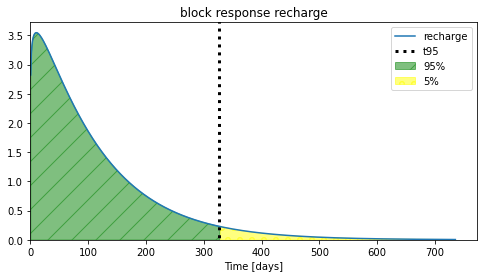

In [76]:
t95 = resp_func.get_tmax(ml.get_parameters('recharge'), cutoff=0.95)
print(f'geheugen (t95) -> {t95:.0f} dagen')

ax = ml.plots.block_response(figsize=(8,4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=3)

block_response = sm.rfunc.block(ml.get_parameters('recharge'))

ax.fill_between(range(1,len(block_response)+1), 0, block_response, 
                where=range(len(block_response)) < t95, hatch='/',
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1,len(block_response)+1), 0, block_response, 
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('block response recharge');

## Fit report pastas<a name="fitreport"></a>

<p style="color:red">%% DB: Pastas specifiek weer...? </p> 

Een groot deel van de hierboven besproken tools voor het beoordelen van een model worden in pastas automatisch getoond na het optimaliseren van een tijdreeksmodel met `ml.solve()`. Dit zogenaamde fit rapport geeft een overzicht van de resultaten van de optimalisatie. Het rapport bestaat uit 4 onderdelen:
- Algemene modelinstellingen (linksboven)
- Fit statistieken (rechtsboven)
- Parameters (midden)
- Parameter correlaties (onder)

Hieronder is een fit rapport weergegeven, daaronder is per onderdeel aangegeven welke resultaten worden getoond.

In [33]:
ml.solve(tmin='1990')

Fit report peilbuis 101          Fit Statistics
nfev     20                     EVP          87.18
nobs     323                    R2            0.87
noise    True                   RMSE          0.12
tmin     1990-01-30 00:00:00    AIC           6.79
tmax     2017-05-30 00:00:00    BIC          25.68
freq     D                      Obj           1.43
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   480.819216   ±7.59%  210.475594  True
recharge_n     1.098409   ±3.48%    1.000000  True
recharge_a   102.749876  ±11.53%   10.000000  True
constant_d    29.888102   ±0.08%   30.124737  True
noise_alpha   45.193179  ±15.23%   17.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.83
           constant_d -0.77
recharge_n recharge_a -0.79
recharge_a constant_d -0.64


**Algemene modelinstellingen**<br>
Hier worden een aantal instellingen en resultaten genoemd van het model. Dit zijn:
- `nfev`: Het aantal model simulaties dat is uitgevoerd door het optimalisatie-algoritme voordat de optimale parameters zijn gevonden. Wanneer de optimale oplossing niet gevonden kan worden en het maximaal aantal functie-evaluaties is berijkt wordt een waarschuwing gegeven.
- `nobs`: Het aantal metingen dat is gebruikt om de model simulatie te fitten op de metingen. In ons geval is dat het aantal metingen in `oseries1`.
- `noise`: parameters om aan te geven of het noise model is gebruikt bij de optimalisatie. Meer informatie over het noisemodel is hier te vinden %%REFERENTIE%%
- `tmin` and `tmax`: de start en de eindtijd van de metingen die gebruikt worden om het model te optimaliseren. Deze kunnen worden opgegeven in de `ml.solve()` functie. Standaard wordt de start- en eindtijd van de `oseries` gebruikt. In dit geval is aangegeven dat als starttijd 1 januari 1990 gebruikt moet worden.
- `freq`: de frequentie van het tijdreeksmodel. Standaard wordt een dagelijkse frequentie gebruikt %%KLOPT DIT????%%. Dit betekent dat de gesimuleerde en gemeten waarde op dagbasis worden vergeleken indien er metingen beschikbaar zijn op een dag.
- `warmup`: De inlooptijd van het model. De grondwaterstanden op een bepaalde dag hangen af van de externe invloeden (stresses) over een bepaalde periode voor deze dag. We weten de lengte van deze periode niet. Standaard wordt een inlooptijd van 10 jaar min de starttijd `tmin` van het model gebruikt.
- `solver`: Het optimalisatie-algoritme dat wordt gebruikt om de gesimuleerde grondwaterstanden te fitten op de gemeten grondwaterstanden. Met de standaard instellingen wordt gebruikt gemaakt van de [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) solver uit de `scipy` package.

**Fit statistics**<br>
Rechtsboven in het model rapport
Deze statistieken geven informatie over de fit tussen gesimuleerde en gemeten grondwaterstanden. De volgende fit parameters worden getoond: 
- `EVP`: Explained variance ook wel bekend als de Nash Sutcliffe coëfficiënt. Een waarde van 100% betekent dat de gemodelleerde en gesimuleerde grondwaterstanden volledige overeenkomen. In de praktijk komt dat niet voor. Meestal wordt een fit hoger dan 60-80% acceptabel geacht om de modelresultaten verder te gebruiken.
- `R2`: the $R^2$ waarde wordt ook wel de determinatiecoëfficiënt genoemd. Een waarde van 1 staat voor een optimale fit.
- `RMSE`: de root mean squared error. Een waarde van 0 staat voor een optimale fit. 
- `AIC`: the Aikake Information Criterion.
- `BIC`: the Bayesan Information Criterion. 

**Parameters**<br>
Dit deel geeft de parameter waarde weer die zijn gevonden met het optimalisatie algoritme. Behalve de optimale waarde wordt ook de standaard deviatie en de initiële waarde weergegeven. In de laatste kolom is aangegeven of de parameter wel `vary=True` of niet `vary=False` is meegenomen in de optimalisatie.

**Parameter correlations**<br>
Deze sectie geeft de correlaties tussen de parameters aan. Alleen de correlaties met een absolute waarde hoger dan 0.5 zijn weergegeven. Wanneer twee parameters een correlatie van 1 of -1 hebben betekent dit dat vergelijkbare modelresultaten bereikt kunnen worden met een verschillende set van de twee parameters.